# 1 IMPORT LIBRARIES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../src')
from data_processing import load_data, get_column_index
from visualization import plot_distribution, plot_countplot, plot_pie_chart, plot_boxplot, plot_heatmap

# 2. Data Loading

In [2]:
data, header = load_data('../data/raw/BankChurners.csv')

In [3]:
print(f"Shape: {data.shape}")

print("=" * 70)
print(f"{'Idx':<5} | {'Column Name':<30} | {'Type':<10} | {'Unique Values':<10}")
print("-" * 70)

for i, col_name in enumerate(header):
    col_data = data[:, i]
    unique_count = len(np.unique(col_data.astype(str)))
    try:
        float_vals = col_data.astype(float)
        has_nan = np.isnan(float_vals).any()
        has_decimal = np.any(np.mod(np.nan_to_num(float_vals), 1) != 0)
        
        if has_nan or has_decimal:
            col_type = "Float"
        else:
            col_type = "Int"
    except ValueError:
        col_type = "String"
    print(f"{i:<5} | {col_name:<30} | {col_type:<10} | {unique_count:<10}")
    
print("=" * 70)

Shape: (10127, 23)
Idx   | Column Name                    | Type       | Unique Values
----------------------------------------------------------------------
0     | CLIENTNUM                      | Int        | 10127     
1     | Attrition_Flag                 | String     | 2         
2     | Customer_Age                   | Int        | 45        
3     | Gender                         | String     | 2         
4     | Dependent_count                | Int        | 6         
5     | Education_Level                | String     | 7         
6     | Marital_Status                 | String     | 4         
7     | Income_Category                | String     | 6         
8     | Card_Category                  | String     | 4         
9     | Months_on_book                 | Int        | 44        
10    | Total_Relationship_Count       | Int        | 6         
11    | Months_Inactive_12_mon         | Int        | 7         
12    | Contacts_Count_12_mon          | Int        | 7       

# 3. Data Cleaning

Mục tiêu của bài toán là dự đoán trạng thái tài khoản của khách hàng (Attrition_Flag), tức là phân loại khách hàng thành “Attrited Customer” hay “Existing Customer” dựa trên các đặc trưng.

Trong bộ dữ liệu gốc có 23 features, trong đó cột `CLIENTNUM` là mã định danh khách hàng và 2 cột cuối là kết quả từ mô hình Naive Bayes (`Naive_Bayes_Classifier_..._1` và `Naive_Bayes_Classifier_..._2`). Các cột này không mang ý nghĩa đặc trưng đầu vào cho bài toán dự đoán hiện tại, đồng thời có thể gây rò rỉ thông tin (data leakage) nếu giữ lại trong quá trình huấn luyện mô hình.

Vì vậy, bước làm sạch dữ liệu đầu tiên là loại bỏ các cột không cần thiết này. Sau khi loại `CLIENTNUM` và hai cột `Naive_Bayes_Classifier_...`, bộ dữ liệu còn lại 20 biến, bao gồm 14 biến numeric và 6 biến categorical, sẽ được sử dụng cho các bước phân tích tiếp theo.

In [4]:
cols_to_remove_names = [
    "CLIENTNUM",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2"
]

indices_to_remove = [get_column_index(header, name) for name in cols_to_remove_names if name in header]
data = np.delete(data, indices_to_remove, axis=1)
header = [col for col in header if col not in cols_to_remove_names]
    
print(f"Đã xóa các index: {indices_to_remove}")
print(f"Shape sau khi xóa: {data.shape}")

Đã xóa các index: [0, 21, 22]
Shape sau khi xóa: (10127, 20)


## 3.1 Kiểm tra Missing Values

In [5]:
print(f"{'Column':<30} | {'Missing':<25}")
print("-" * 60)

for i, col in enumerate(header):
    col_data_str = data[:, i].astype(str)
    is_missing = (col_data_str == "") | (np.char.lower(col_data_str) == "nan")
    count_missing = np.sum(is_missing)
    pct_missing = (count_missing / len(data)) * 100
    str_missing = f"{count_missing:>5} ({pct_missing:>6.2f}%)"
    
    print(f"{col:<30} | {str_missing:<25}")

Column                         | Missing                  
------------------------------------------------------------
Attrition_Flag                 |     0 (  0.00%)          
Customer_Age                   |     0 (  0.00%)          
Gender                         |     0 (  0.00%)          
Dependent_count                |     0 (  0.00%)          
Education_Level                |     0 (  0.00%)          
Marital_Status                 |     0 (  0.00%)          
Income_Category                |     0 (  0.00%)          
Card_Category                  |     0 (  0.00%)          
Months_on_book                 |     0 (  0.00%)          
Total_Relationship_Count       |     0 (  0.00%)          
Months_Inactive_12_mon         |     0 (  0.00%)          
Contacts_Count_12_mon          |     0 (  0.00%)          
Credit_Limit                   |     0 (  0.00%)          
Total_Revolving_Bal            |     0 (  0.00%)          
Avg_Open_To_Buy                |     0 (  0.00%)      

## 3.2 Kiểm tra Duplicate Values

In [6]:
data_for_check = data.astype(str)
unique_rows = np.unique(data_for_check, axis=0)
n_total = len(data)
n_unique = len(unique_rows)
n_duplicates = n_total - n_unique
percent = (n_duplicates / n_total) * 100

print(f"Tổng số dòng dữ liệu: {n_total}")
print(f"Số dòng duy nhất:     {n_unique}")
print(f"Số dòng trùng lặp:    {n_duplicates}")
print(f"Tỷ lệ trùng lặp:      {percent:.2f}%")

Tổng số dòng dữ liệu: 10127
Số dòng duy nhất:     10127
Số dòng trùng lặp:    0
Tỷ lệ trùng lặp:      0.00%


## 3.3 Kiểm tra Outliers

**Tứ phân vị (IQR):**

* Tính $Q1$ (Tứ phân vị thứ nhất - 25%) và $Q3$ (Tứ phân vị thứ ba - 75%).
* Tính khoảng tứ phân vị: $IQR = Q3 - Q1$.
* Xác định các ngưỡng giới hạn:
    * $Lower Bound = Q1 - 1.5 \times IQR$
    * $Upper Bound = Q3 + 1.5 \times IQR$
* Bất kỳ điểm dữ liệu nào nằm ngoài khoảng `[Lower Bound, Upper Bound]` đều được xem là outlier.

In [7]:
numeric_cols = [col for i, col in enumerate(header) if isinstance(data[0, i], (int, float))]

print(f"{'Column':<30} | {'Outliers':<10} | {'(%)':<8} | {'Lower Bound':<12} | {'Upper Bound':<12}")
print("-" * 90)

for col in numeric_cols:
    col_idx = header.index(col)
    col_data = data[:, col_idx].astype(float)
    
    q1, q3 = np.percentile(col_data, [25, 75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    
    n_outliers = np.sum((col_data < lower) | (col_data > upper))
    pct_outliers = (n_outliers / len(data)) * 100
    
    print(f"{col:<30} | {n_outliers:<10} | {pct_outliers:<7.2f}% | {lower:<12.2f} | {upper:<12.2f}")

Column                         | Outliers   | (%)      | Lower Bound  | Upper Bound 
------------------------------------------------------------------------------------------
Customer_Age                   | 2          | 0.02   % | 24.50        | 68.50       
Dependent_count                | 0          | 0.00   % | -2.00        | 6.00        
Months_on_book                 | 386        | 3.81   % | 17.50        | 53.50       
Total_Relationship_Count       | 0          | 0.00   % | 0.00         | 8.00        
Months_Inactive_12_mon         | 331        | 3.27   % | 0.50         | 4.50        
Contacts_Count_12_mon          | 629        | 6.21   % | 0.50         | 4.50        
Credit_Limit                   | 984        | 9.72   % | -10213.75    | 23836.25    
Total_Revolving_Bal            | 0          | 0.00   % | -1778.50     | 3921.50     
Avg_Open_To_Buy                | 963        | 9.51   % | -11477.25    | 22660.75    
Total_Amt_Chng_Q4_Q1           | 396        | 3.91   % | 0.

### Nhận xét về Outliers

**1. Nhóm có tỷ lệ Outlier cao:**
Các biến tài chính quan trọng ghi nhận tỷ lệ ngoại lai cao nhất (xấp xỉ 9-10%), phản ánh phân phối lệch phải. Điều này cho thấy sự tồn tại của một nhóm khách hàng có hành vi chi tiêu vượt trội hoặc hạn mức tín dụng cao hơn hẳn so với phần còn lại.
* **`Credit_Limit` (9.72%)**, **`Avg_Open_To_Buy` (9.51%)** và **`Total_Trans_Amt` (8.85%)**

**2. Nhóm có tỷ lệ Outlier trung bình:**
* **`Contacts_Count_12_mon` (6.21%)**: Tỷ lệ ngoại lai đạt mức trên 6%. Việc khách hàng có tần suất liên hệ cao bất thường (vượt ngưỡng trên) có thể là dấu hiệu của các vấn đề cần giải quyết hoặc sự không hài lòng – một chỉ báo tiềm năng cho nguy cơ rời bỏ (churn).

**Kết luận:**
Sự xuất hiện dày đặc của outlier ở các biến tài chính (`Credit_Limit`, `Total_Trans_Amt`) mang ý nghĩa quan trọng về hành vi của phân khúc khách hàng cao cấp thay vì là lỗi dữ liệu. Do đó, việc loại bỏ các giá trị này có thể làm mất thông tin quan trọng. Có thể thấy, đây không hẳn là outlier làm nhiễu dữ liệu mà nó là 1 phần dữ liệu quan trọng.

## 3.4 Kết luận Data Cleaning

Sau khi thực hiện các bước kiểm tra và làm sạch dữ liệu, có thể rút ra các kết luận sau về chất lượng bộ dữ liệu:
- Không tồn tại **Missing Values**
- Không có **Duplicate Values**
- không loại bỏ **Outliers** để tránh mất mát thông tin quan trọng

**Tổng kết:** Dữ liệu đã sẵn sàng cho giai đoạn Phân tích Khám phá Dữ liệu (Exploratory Data Analysis - EDA)

In [8]:
data[0:5]

array([['Existing Customer', 45, 'M', 3, 'High School', 'Married',
        '$60K - $80K', 'Blue', 39, 5, 1, 3, 12691.0, 777, 11914.0, 1.335,
        1144, 42, 1.625, 0.061],
       ['Existing Customer', 49, 'F', 5, 'Graduate', 'Single',
        'Less than $40K', 'Blue', 44, 6, 1, 2, 8256.0, 864, 7392.0,
        1.541, 1291, 33, 3.714, 0.105],
       ['Existing Customer', 51, 'M', 3, 'Graduate', 'Married',
        '$80K - $120K', 'Blue', 36, 4, 1, 0, 3418.0, 0, 3418.0, 2.594,
        1887, 20, 2.333, 0.0],
       ['Existing Customer', 40, 'F', 4, 'High School', 'Unknown',
        'Less than $40K', 'Blue', 34, 3, 4, 1, 3313.0, 2517, 796.0,
        1.405, 1171, 20, 2.333, 0.76],
       ['Existing Customer', 40, 'M', 3, 'Uneducated', 'Married',
        '$60K - $80K', 'Blue', 21, 5, 1, 0, 4716.0, 0, 4716.0, 2.175,
        816, 28, 2.5, 0.0]], dtype=object)

In [9]:
header_str = ",".join(header)
np.savetxt('../data/processed/data_after_eda.csv', data, delimiter=',', header=header_str, fmt='%s', comments='', encoding='utf-8')

# 4. Exploratory Data Analysis - EDA

## 4.1 Target Variable: Attrition

PHÂN BỐ ATTRITION (MỤC TIÊU)
Attrited Customer   :  1627 (16.07%)
Existing Customer   :  8500 (83.93%)


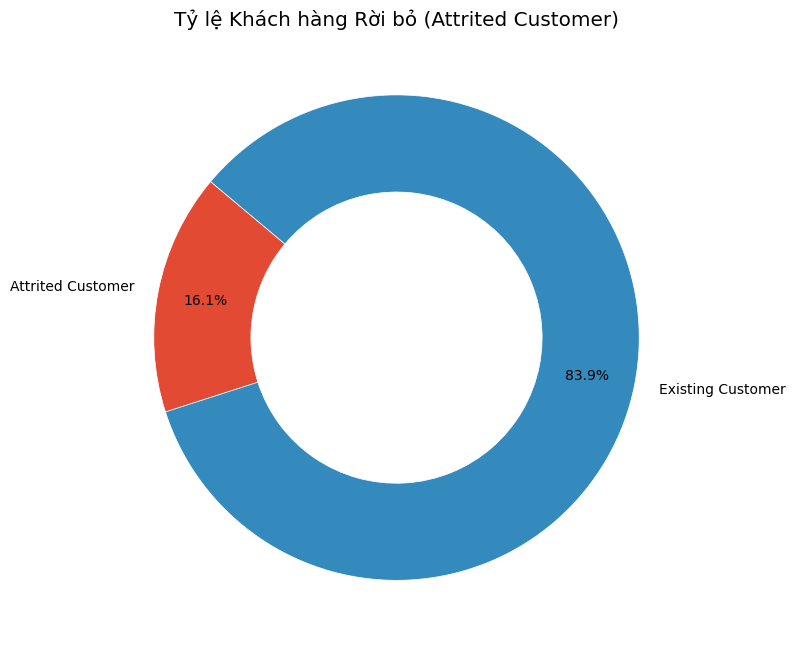

In [10]:
attrition_idx = get_column_index(header, 'Attrition_Flag')
attrition_values = data[:, attrition_idx]
unique_values, counts = np.unique(attrition_values, return_counts=True)
percentages = counts / len(attrition_values) * 100

print("PHÂN BỐ ATTRITION (MỤC TIÊU)")
for val, count, pct in zip(unique_values, counts, percentages):
    print(f"{val:20s}: {count:5d} ({pct:5.2f}%)")

plot_pie_chart(counts, unique_values, 'Tỷ lệ Khách hàng Rời bỏ (Attrited Customer)')

## 4.2 Phân bố Thông tin Khách hàng

THỐNG KÊ TUỔI KHÁCH HÀNG
Trung bình (Mean):   46.33 tuổi
Trung vị (Median):   46.00 tuổi
Độ lệch chuẩn (Std): 8.02
Nhỏ nhất (Min):      26 tuổi
Lớn nhất (Max):      73 tuổi


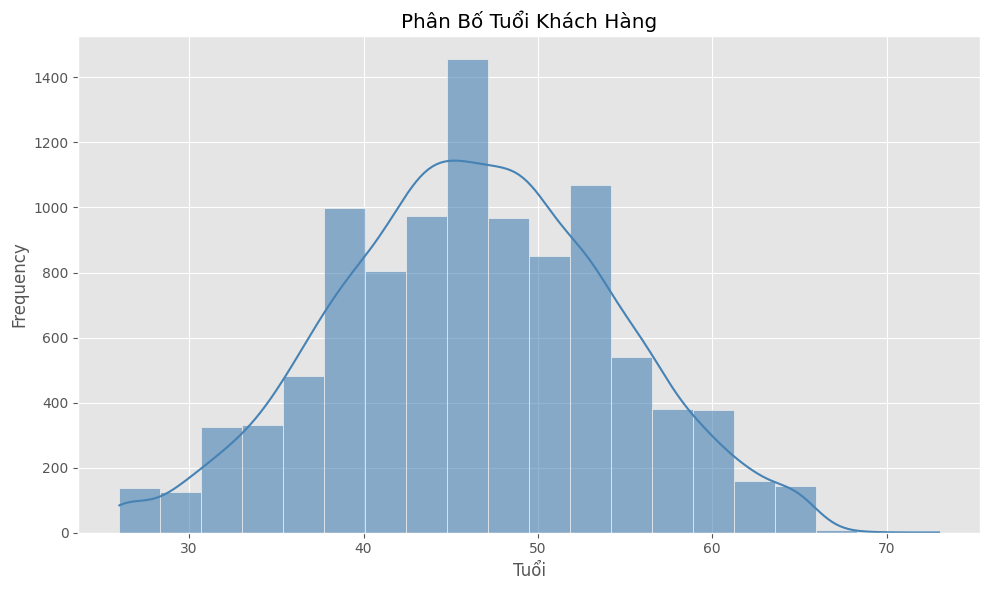

In [11]:
age_idx = get_column_index(header, 'Customer_Age')
ages = data[:, age_idx].astype(float)

age_mean = np.mean(ages)
age_median = np.median(ages)
age_std = np.std(ages)
age_min = np.min(ages)
age_max = np.max(ages)

print("THỐNG KÊ TUỔI KHÁCH HÀNG")
print(f"Trung bình (Mean):   {age_mean:.2f} tuổi")
print(f"Trung vị (Median):   {age_median:.2f} tuổi")
print(f"Độ lệch chuẩn (Std): {age_std:.2f}")
print(f"Nhỏ nhất (Min):      {age_min:.0f} tuổi")
print(f"Lớn nhất (Max):      {age_max:.0f} tuổi")

plot_distribution(ages, 'Phân Bố Tuổi Khách Hàng', 'Tuổi', bins=20)

Gender     | Attrited   | Existing   | % Churn   
--------------------------------------------------
Female     | 930        | 4428       | 17.36 %
Male       | 697        | 4072       | 14.62 %


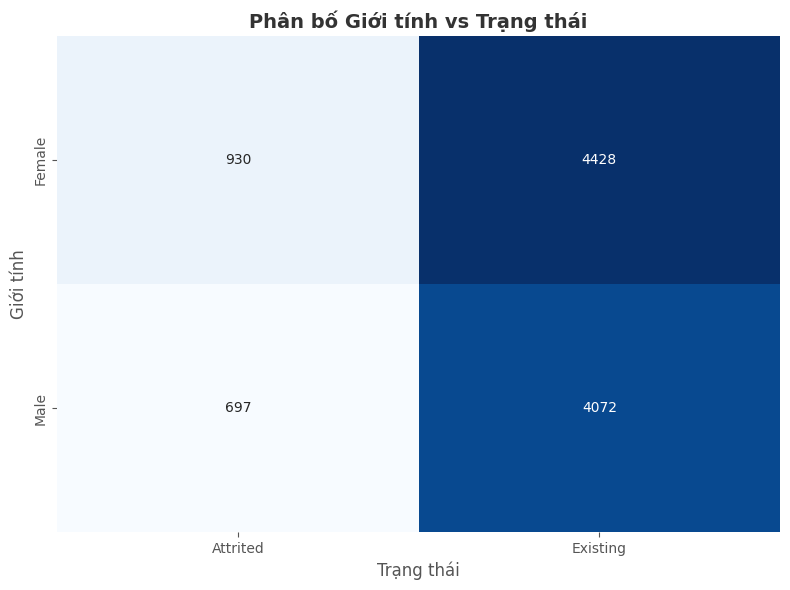

In [12]:
gender_idx = get_column_index(header, 'Gender')
attrition_idx = get_column_index(header, 'Attrition_Flag')

genders = ['F', 'M']
statuses = ['Attrited Customer', 'Existing Customer']
matrix_counts = np.zeros((len(genders), len(statuses)), dtype=int)

for i, g in enumerate(genders):
    for j, s in enumerate(statuses):
        matrix_counts[i, j] = np.sum((data[:, gender_idx] == g) & (data[:, attrition_idx] == s))

print(f"{'Gender':<10} | {'Attrited':<10} | {'Existing':<10} | {'% Churn':<10}")
print('-'*50)

for i, g in enumerate(genders):
    total = np.sum(matrix_counts[i])
    churn_rate = (matrix_counts[i, 0] / total) * 100
    name = "Female" if g == 'F' else "Male"
    print(f"{name:<10} | {matrix_counts[i, 0]:<10} | {matrix_counts[i, 1]:<10} | {churn_rate:<6.2f}%")

plot_heatmap(matrix_counts, 
             ['Attrited', 'Existing'], 
             ['Female', 'Male'], 
             'Phân bố Giới tính vs Trạng thái', 
             'Trạng thái', 
             'Giới tính')

Trình độ học vấn     | Số lượng Khách Hàng
---------------------------------------------
College              | 1013           
Doctorate            | 451            
Graduate             | 3128           
High School          | 2013           
Post-Graduate        | 516            
Uneducated           | 1487           
Unknown              | 1519           


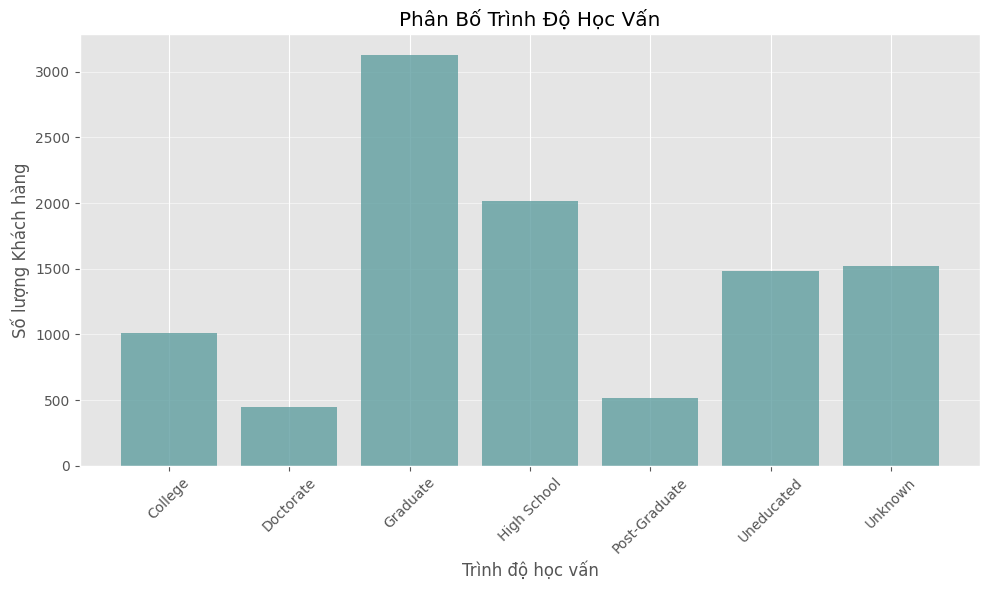

In [13]:
edu_idx = get_column_index(header, 'Education_Level')
edu_data = data[:, edu_idx]
unique_vals, counts = np.unique(edu_data, return_counts=True)

print(f"{'Trình độ học vấn':<20} | {'Số lượng Khách Hàng':<15}")
print("-" * 45)

for val, count in zip(unique_vals, counts):
    print(f"{val:<20} | {count:<15}")

plot_countplot(unique_vals, counts, 
               'Phân Bố Trình Độ Học Vấn', 
               'Trình độ học vấn', 
               'Số lượng Khách hàng')

Thu nhập                  | Số lượng Khách hàng
---------------------------------------------
$120K +                   | 727            
$40K - $60K               | 1790           
$60K - $80K               | 1402           
$80K - $120K              | 1535           
Less than $40K            | 3561           
Unknown                   | 1112           


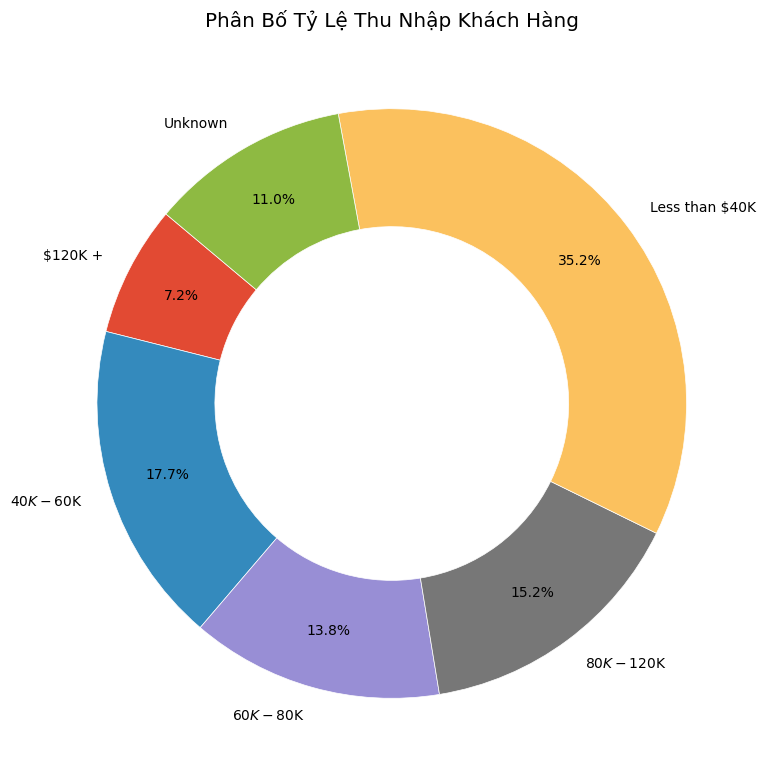

In [14]:
inc_idx = get_column_index(header, 'Income_Category')
inc_data = data[:, inc_idx]
unique_vals, counts = np.unique(inc_data, return_counts=True)

print(f"{'Thu nhập':<25} | {'Số lượng Khách hàng':<15}")
print("-" * 45)

for val, count in zip(unique_vals, counts):
    print(f"{val:<25} | {count:<15}")

plot_pie_chart(counts, unique_vals, 'Phân Bố Tỷ Lệ Thu Nhập Khách Hàng')

## 4.3 Phân tích Mức độ Gắn kết Khách hàng

Phân bố Loại thẻ: {'Blue': np.int64(9436), 'Gold': np.int64(116), 'Platinum': np.int64(20), 'Silver': np.int64(555)}


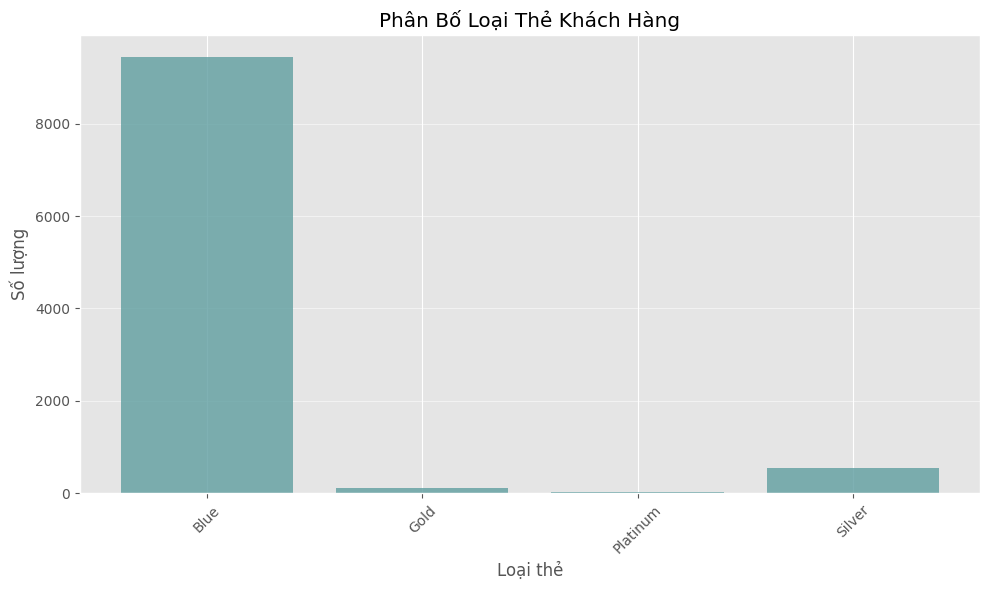

In [15]:
card_idx = get_column_index(header, 'Card_Category')
card_data = data[:, card_idx]

unique_vals, counts = np.unique(card_data, return_counts=True)

print(f"Phân bố Loại thẻ: {dict(zip(unique_vals, counts))}")
plot_countplot(unique_vals, counts, 
               'Phân Bố Loại Thẻ Khách Hàng', 
               'Loại thẻ', 
               'Số lượng')

Trung bình (Mean): 35.93 tháng
Nhỏ nhất (Min):    13 tháng
Lớn nhất (Max):    56 tháng


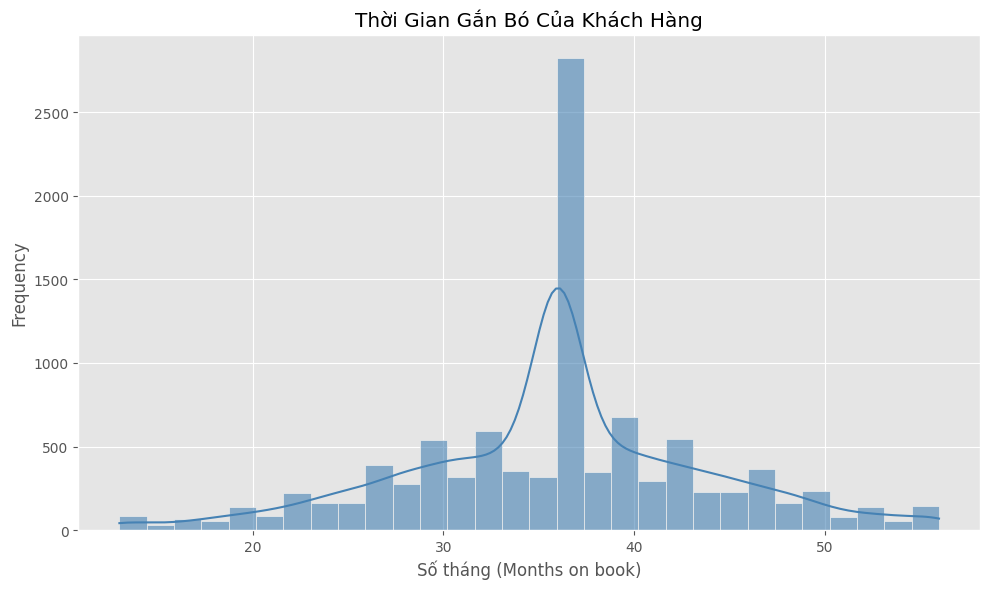

In [16]:
mob_idx = get_column_index(header, 'Months_on_book')
mob_data = data[:, mob_idx].astype(float)

print(f"Trung bình (Mean): {np.mean(mob_data):.2f} tháng")
print(f"Nhỏ nhất (Min):    {np.min(mob_data):.0f} tháng")
print(f"Lớn nhất (Max):    {np.max(mob_data):.0f} tháng")

plot_distribution(mob_data, 
                  'Thời Gian Gắn Bó Của Khách Hàng', 
                  'Số tháng (Months on book)', 
                  bins=30)

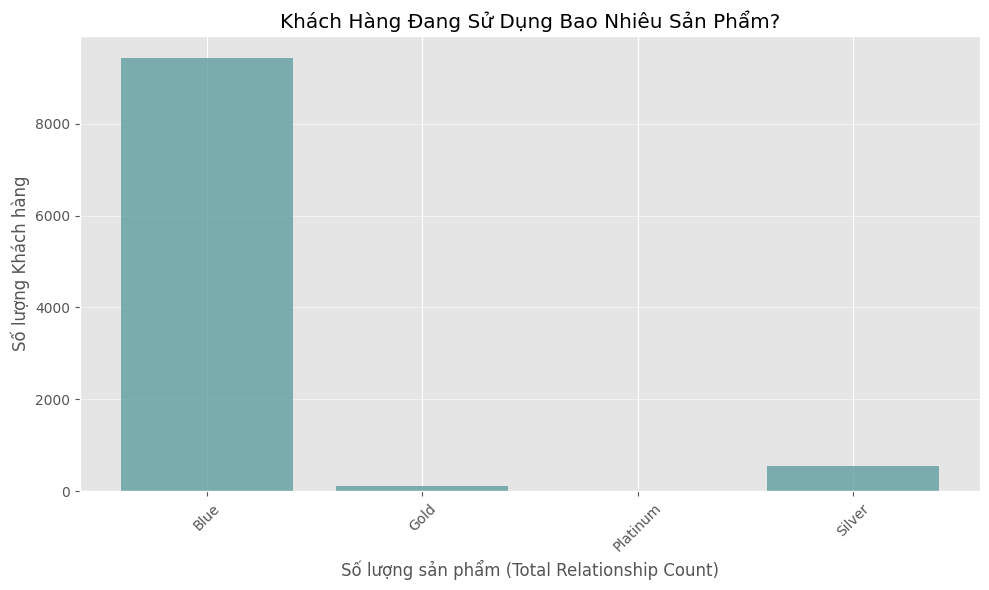

In [17]:
rel_idx = get_column_index(header, 'Total_Relationship_Count')
rel_data = data[:, rel_idx].astype(float)

plot_countplot(unique_vals, counts, 
               'Khách Hàng Đang Sử Dụng Bao Nhiêu Sản Phẩm?', 
               'Số lượng sản phẩm (Total Relationship Count)', 
               'Số lượng Khách hàng')

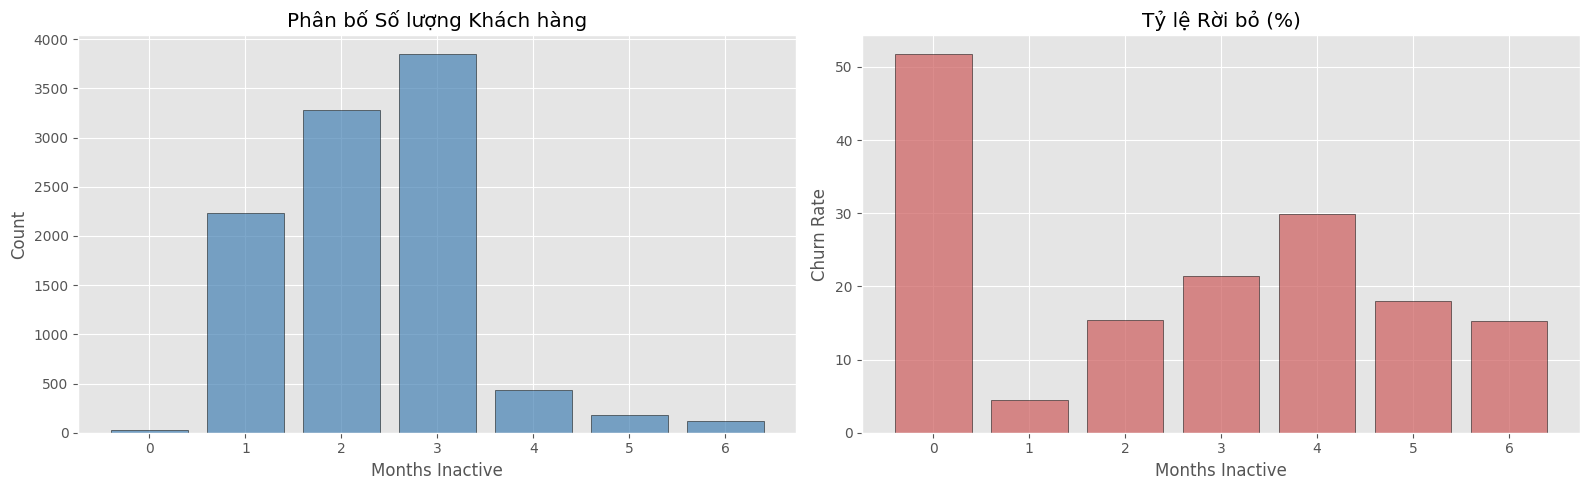

In [18]:
vals = data[:, get_column_index(header, 'Months_Inactive_12_mon')].astype(float)
att = data[:, get_column_index(header, 'Attrition_Flag')]
unique, counts = np.unique(vals, return_counts=True)
rates = [np.mean(att[vals==u] == 'Attrited Customer')*100 for u in unique]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.bar(unique, counts, color='steelblue', edgecolor='k', alpha=0.7)
ax1.set(title='Phân bố Số lượng Khách hàng', xlabel='Months Inactive', ylabel='Count')
ax2.bar(unique, rates, color='indianred', edgecolor='k', alpha=0.7)
ax2.set(title='Tỷ lệ Rời bỏ (%)', xlabel='Months Inactive', ylabel='Churn Rate')

plt.tight_layout(); plt.show()

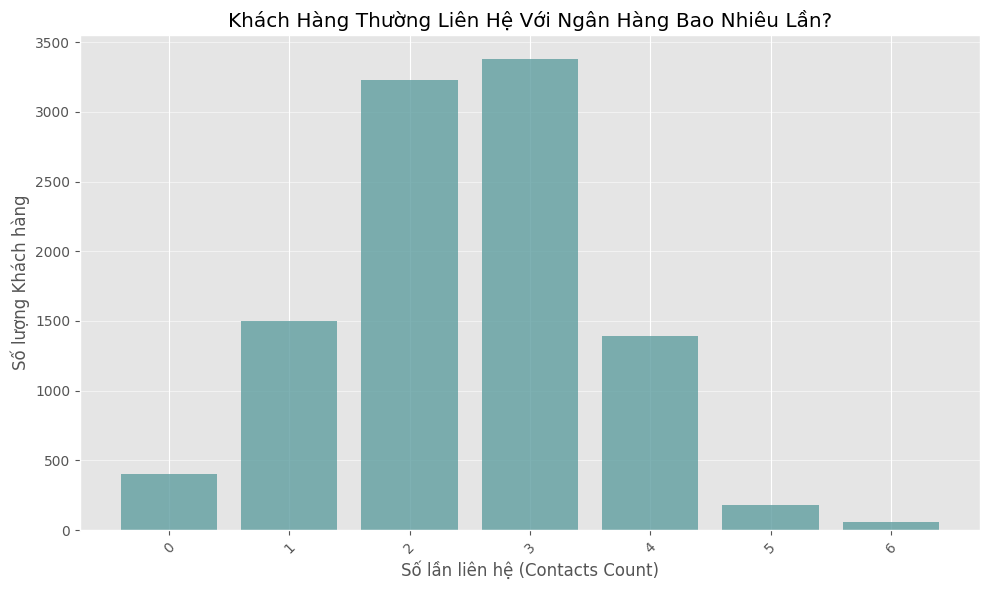

In [19]:
contact_idx = get_column_index(header, 'Contacts_Count_12_mon')
contact_data = data[:, contact_idx].astype(float)

unique_vals, counts = np.unique(contact_data, return_counts=True)
sorted_indices = np.argsort(unique_vals)

plot_countplot(unique_vals[sorted_indices], counts[sorted_indices], 
               'Khách Hàng Thường Liên Hệ Với Ngân Hàng Bao Nhiêu Lần?', 
               'Số lần liên hệ (Contacts Count)', 
               'Số lượng Khách hàng')

## 4.4 Phân tích Hành vi Tài chính

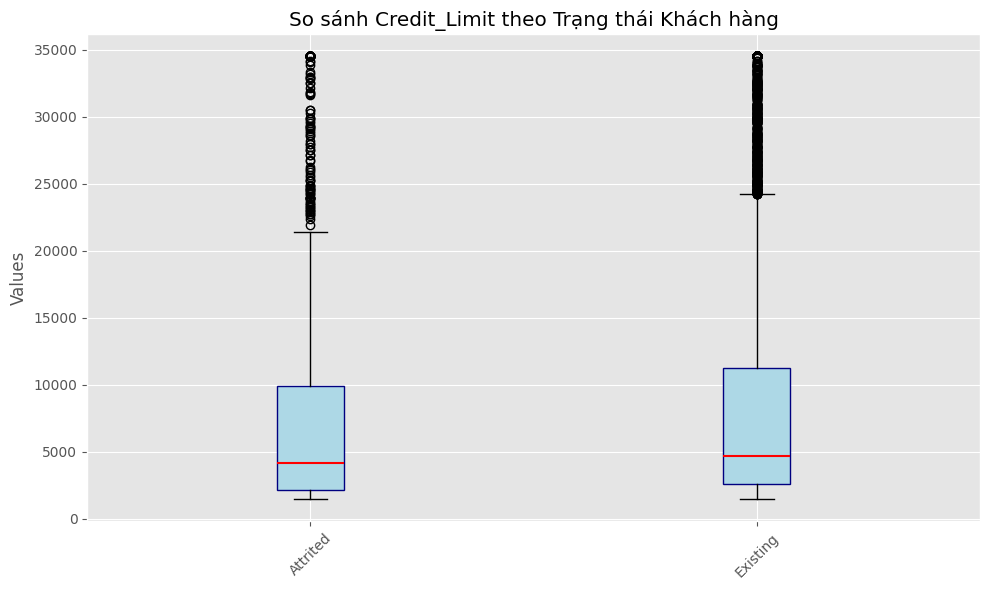

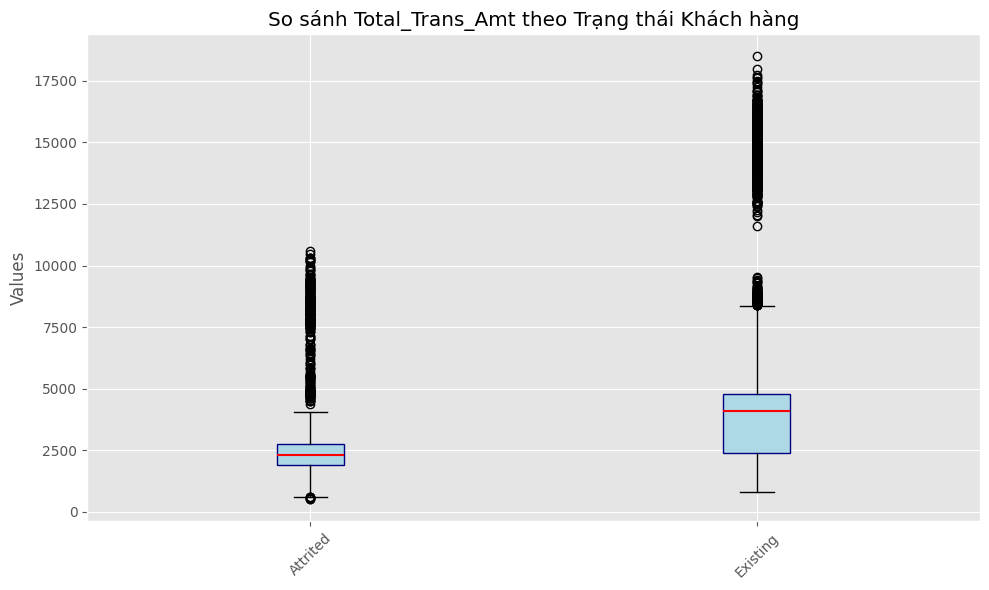

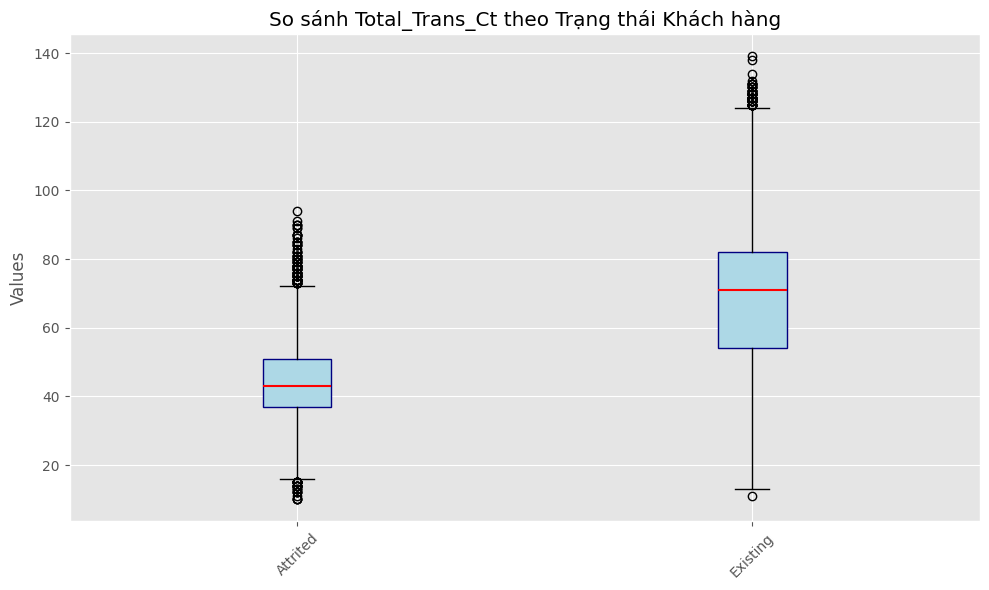

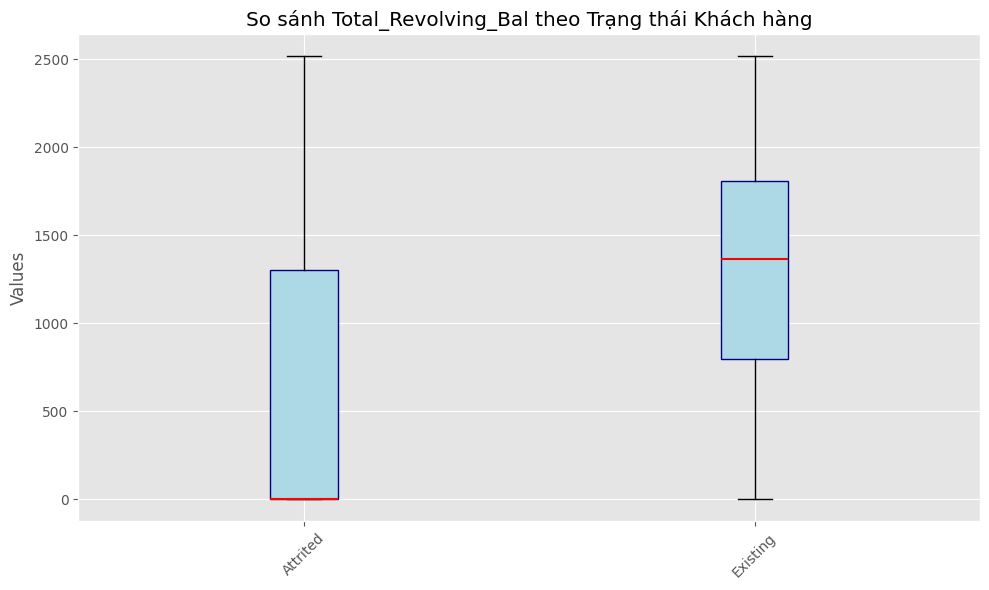

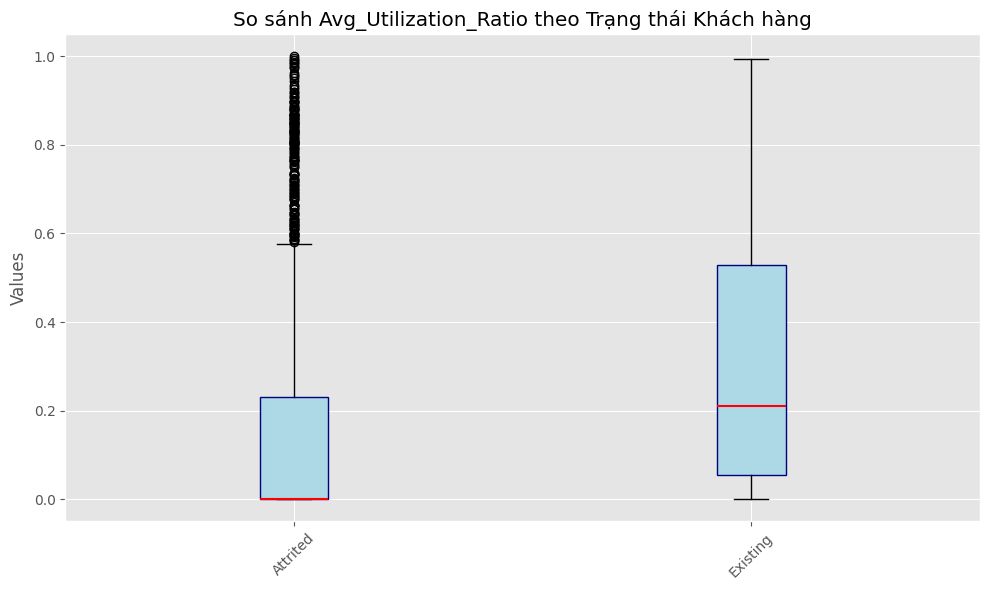

In [20]:
features_to_boxplot = [
    "Credit_Limit", 
    "Total_Trans_Amt", 
    "Total_Trans_Ct", 
    "Total_Revolving_Bal", 
    "Avg_Utilization_Ratio"
]

for col in features_to_boxplot:
    idx = get_column_index(header, col)
    col_data = data[:, idx].astype(float)
    
    attrited_data = col_data[data[:, get_column_index(header, 'Attrition_Flag')] == 'Attrited Customer']
    existing_data = col_data[data[:, get_column_index(header, 'Attrition_Flag')] == 'Existing Customer']
    
    plot_boxplot([attrited_data, existing_data], 
                 ['Attrited', 'Existing'], 
                 f'So sánh {col} theo Trạng thái Khách hàng')

### Nhận xét

Phân tích biểu đồ hộp (Boxplot) cho thấy sự khác biệt rõ rệt giữa nhóm **Attrited** và **Existing**:

1. **Mức độ giao dịch (Total_Trans_Amt & Total_Trans_Ct):**  
   * Nhóm **Attrited** có **tổng số tiền giao dịch** và **số lượng giao dịch** thấp hơn nhiều. Điều này cho thấy họ **ít sử dụng thẻ**, hoạt động thưa thớt trước khi rời bỏ.

2. **Total_Revolving_Bal:**  
   * Trung vị của biến này ở nhóm **Attrited** gần như bằng 0. Điều này thể hiện rằng họ **không duy trì số dư trên thẻ**, một dấu hiệu thường gặp khi khách hàng **không còn dùng thẻ** hoặc **chuẩn bị đóng tài khoản**.

3. **Hạn mức tín dụng (Credit_Limit):**  
   * Nhóm **Attrited** có hạn mức tín dụng thấp hơn đáng kể. Khách hàng có hạn mức thấp thường **ít gắn bó** hoặc **ít giá trị sử dụng thẻ**.

**Kết luận:** Khách hàng có **mức độ sử dụng thẻ thấp**, **ít giao dịch**, **không duy trì số dư**, và **hạn mức thấp** là những dấu hiệu mạnh cho thấy **nguy cơ rời bỏ cao**.


# 5. Phân tích & Nhận định

## Câu hỏi 1: Các yếu tố Nhân khẩu học (Giới tính, Tuổi, Thu nhập, Học vấn, Hôn nhân) ảnh hưởng như thế nào đến tỷ lệ rời bỏ?


PHÂN TÍCH TỶ LỆ RỜI BỎ THEO: GENDER
-------------------------------------------------------
Nhóm            | Tổng KH    | Rời bỏ     | Tỷ lệ (%) 
-------------------------------------------------------
F               | 5358       | 930        | 17.36     %
M               | 4769       | 697        | 14.62     %

PHÂN TÍCH TỶ LỆ RỜI BỎ THEO: EDUCATION_LEVEL
-------------------------------------------------------
Nhóm            | Tổng KH    | Rời bỏ     | Tỷ lệ (%) 
-------------------------------------------------------
College         | 1013       | 154        | 15.20     %
Doctorate       | 451        | 95         | 21.06     %
Graduate        | 3128       | 487        | 15.57     %
High School     | 2013       | 306        | 15.20     %
Post-Graduate   | 516        | 92         | 17.83     %
Uneducated      | 1487       | 237        | 15.94     %
Unknown         | 1519       | 256        | 16.85     %

PHÂN TÍCH TỶ LỆ RỜI BỎ THEO: INCOME_CATEGORY
---------------------------------

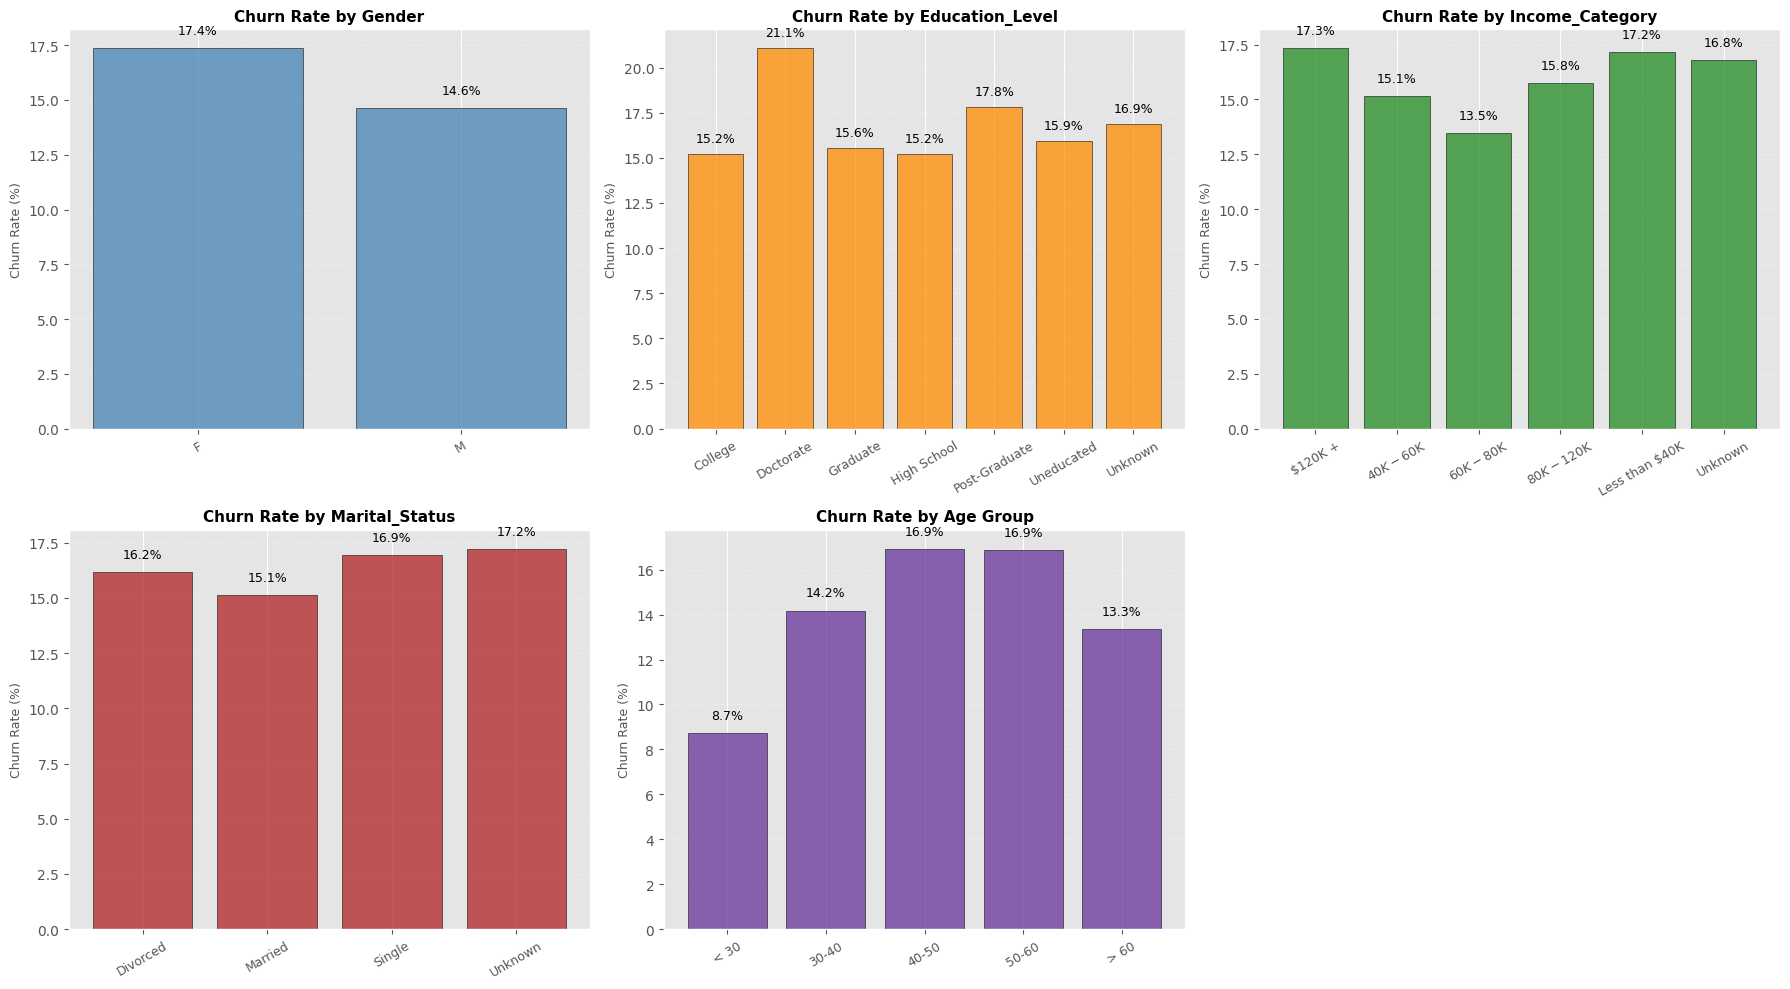

In [21]:
features_to_analyze = [
    ('Gender', None),
    ('Education_Level', None),
    ('Income_Category', None),
    ('Marital_Status', None),
    ('Age Group', 'Customer_Age_Binning')
]

plot_data_storage = {}
attrition_col = data[:, get_column_index(header, 'Attrition_Flag')]

age_idx = get_column_index(header, 'Customer_Age')
ages = data[:, age_idx].astype(float)
bins = [0, 30, 40, 50, 60, 100]
labels_age = ['< 30', '30-40', '40-50', '50-60', '> 60']
bin_indices = np.digitize(ages, bins)
age_groups = np.array([labels_age[i-1] for i in bin_indices])

for name, special_type in features_to_analyze:
    if special_type == 'Customer_Age_Binning':
        feature_vals = age_groups
        unique_cats = labels_age
    else:
        col_idx = get_column_index(header, name)
        feature_vals = data[:, col_idx]
        unique_cats = np.unique(feature_vals)

    churn_rates = []
    
    print(f"\n{'='*55}")
    print(f"PHÂN TÍCH TỶ LỆ RỜI BỎ THEO: {name.upper()}")
    print(f"{'-'*55}")
    print(f"{'Nhóm':<15} | {'Tổng KH':<10} | {'Rời bỏ':<10} | {'Tỷ lệ (%)':<10}")
    print(f"{'-'*55}")

    for cat in unique_cats:
        mask_cat = (feature_vals == cat)
        total = np.sum(mask_cat)
        if total == 0: continue
        n_churn = np.sum(mask_cat & (attrition_col == 'Attrited Customer'))
        rate = (n_churn / total) * 100
        churn_rates.append(rate)
        print(f"{str(cat):<15} | {total:<10} | {n_churn:<10} | {rate:<10.2f}%")
    
    print(f"{'='*55}")
    
    plot_data_storage[name] = {'categories': unique_cats, 'rates': churn_rates}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

plot_colors = ['steelblue', 'darkorange', 'forestgreen', 'firebrick', 'rebeccapurple']

for i, (name, _) in enumerate(features_to_analyze):
    ax = axes[i]
    plot_info = plot_data_storage[name]
    cats = plot_info['categories']
    rates = plot_info['rates']
    color = plot_colors[i % len(plot_colors)]
    bars = ax.bar(cats, rates, color=color, edgecolor='black', alpha=0.75)
    ax.set_title(f'Churn Rate by {name}', fontsize=11, fontweight='bold')
    ax.set_ylabel('Churn Rate (%)', fontsize=9)
    ax.tick_params(axis='x', rotation=30, labelsize=9)
    ax.grid(axis='y', linestyle=':', alpha=0.5)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

if len(features_to_analyze) < len(axes):
    for j in range(len(features_to_analyze), len(axes)):
        axes[j].axis('off')

plt.tight_layout()
plt.show()

### Nhận xét Kết quả Phân tích Churn theo Nhân khẩu học

**1. Giới tính (Gender)**
- Nữ giới có tỷ lệ rời bỏ cao hơn tuy không quá lớn so với Nam giới (**17.4%** > **14.6%**).

**2. Trình độ Học vấn (Education Level)**
- Có thể thấy: hầu hết các nhóm đều ổn định ở mức 15-16%. Riêng nhóm **Doctorate** có tỷ lệ rời bỏ cao vọt lên **21%**.
- Trình độ học vấn không ảnh hưởng nhiều, ngoại trừ nhóm khách hàng có bằng cấp rất cao thì khó giữ chân hơn.

**3. Mức thu nhập (Income Category)**
- Nhóm rủi ro cao tập trung ở hai đầu: `Less than $40K` và `$120K+` (đều ~17%). Nhóm `Unknown` cũng cao (16.8%)
- Thu nhập ảnh hưởng theo hai cực, nhưng mức chênh lệch giữa các nhóm cũng không quá lớn (chỉ khoảng 3-4%).

**4. Tình trạng Hôn nhân (Marital Status)**
- Các nhóm dao động nhẹ quanh mức 15-17%. Yếu tố này tác động rất yếu, không giúp ích nhiều nếu dùng riêng lẻ để dự đoán.

**5. Độ tuổi (Age Group)**
- Có sự chênh lệch rất lớn. Nhóm **Trẻ (<30 tuổi)** rất ít rời bỏ (**8.7%**), trong khi nhóm **Trung niên (40-60 tuổi)** rời bỏ nhiều nhất (**~17%**).

## Câu 2: Phân khúc theo Quy mô Giao dịch (`Avg_Ticket_Size`): Tỷ lệ rời bỏ thay đổi như thế nào giữa các nhóm chi tiêu Thấp, Trung bình và Cao?

PHÂN TÍCH THEO QUY MÔ GIAO DỊCH
--------------------------------------------------
Thấp            | Total: 3342  | Churn Rate: 17.98%
Trung bình      | Total: 3342  | Churn Rate: 13.49%
Cao             | Total: 3443  | Churn Rate: 16.70%


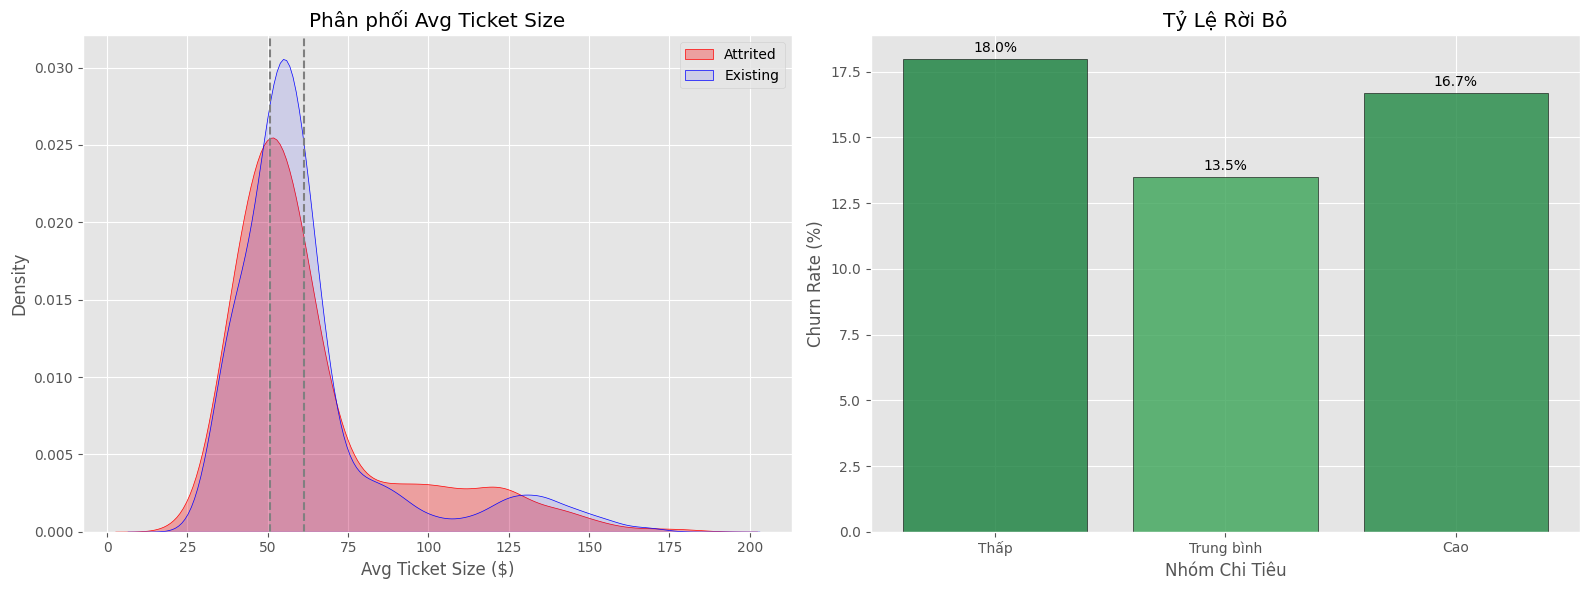

In [22]:
trans_amt = data[:, get_column_index(header, 'Total_Trans_Amt')].astype(float)
trans_ct = data[:, get_column_index(header, 'Total_Trans_Ct')].astype(float)
attrition = data[:, get_column_index(header, 'Attrition_Flag')]

avg_ticket = np.divide(trans_amt, trans_ct, out=np.zeros_like(trans_amt), where=trans_ct!=0)
p33, p66 = np.percentile(avg_ticket, [33, 66])

conditions = [avg_ticket < p33, (avg_ticket >= p33) & (avg_ticket < p66), avg_ticket >= p66]
ticket_groups = np.select(conditions, ['Thấp', 'Trung bình', 'Cao'], default='Unknown')

labels = ['Thấp', 'Trung bình', 'Cao']
churn_rates = []

print(f"{'='*50}\nPHÂN TÍCH THEO QUY MÔ GIAO DỊCH\n{'-'*50}")
for label in labels:
    mask = (ticket_groups == label)
    rate = np.mean(attrition[mask] == 'Attrited Customer') * 100
    churn_rates.append(rate)
    print(f"{label:<15} | Total: {np.sum(mask):<5} | Churn Rate: {rate:.2f}%")
print('='*50)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# KDE Plot
sns.kdeplot(avg_ticket[attrition == 'Attrited Customer'], ax=ax1, color='red', fill=True, alpha=0.3, label='Attrited')
sns.kdeplot(avg_ticket[attrition == 'Existing Customer'], ax=ax1, color='blue', fill=True, alpha=0.1, label='Existing')
ax1.axvline(p33, color='gray', ls='--'); ax1.axvline(p66, color='gray', ls='--')
ax1.set(title='Phân phối Avg Ticket Size', xlabel='Avg Ticket Size ($)'); ax1.legend()

# Bar Plot
bars = ax2.bar(labels, churn_rates, color=plt.cm.Greens(np.array(churn_rates)/30+0.2), edgecolor='k', alpha=0.8)
ax2.set(title='Tỷ Lệ Rời Bỏ', ylabel='Churn Rate (%)', xlabel='Nhóm Chi Tiêu')
ax2.bar_label(bars, fmt='%.1f%%', padding=3)

plt.tight_layout(); plt.show()

## Câu 3: Có sự sụt giảm đáng kể nào trong hành vi giao dịch (`Total_Amt_Chng_Q4_Q1` và `Total_Ct_Chng_Q4_Q1`) giữa Quý 4 và Quý 1 ở nhóm khách hàng rời bỏ so với nhóm hiện tại không? Từ đó có thể nhận biết sự "nguội lạnh" của khách hàng trước khi khi rời bỏ.

Ngưỡng tối ưu (threshold): 0.60 (Độ tách biệt: 41.1%)
PHÂN TÍCH SỰ THAY ĐỔI HÀNH VI GIAO DỊCH (Q4 vs Q1)

--- SO SÁNH: Thay đổi Số Tiền (Total_Amt_Chng_Q4_Q1) ---
Chỉ số               | Attrited    | Existing    | Chênh lệch
------------------------------------------------------------
Median               | 0.70        | 0.74        | -0.04
Tỷ lệ < 0.60         | 33.0      % | 16.7      % | +16.3%


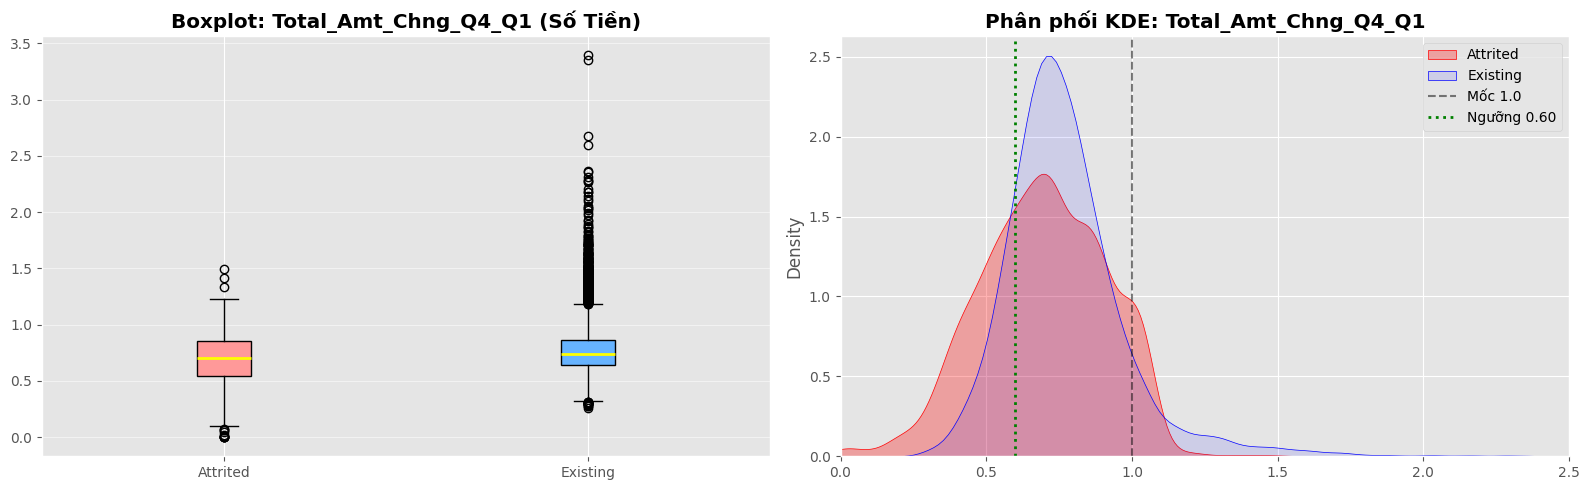


--- SO SÁNH: Thay đổi Số Lần (Total_Ct_Chng_Q4_Q1) ---
Chỉ số               | Attrited    | Existing    | Chênh lệch
------------------------------------------------------------
Median               | 0.53        | 0.72        | -0.19
Tỷ lệ < 0.60         | 63.4      % | 22.2      % | +41.1%


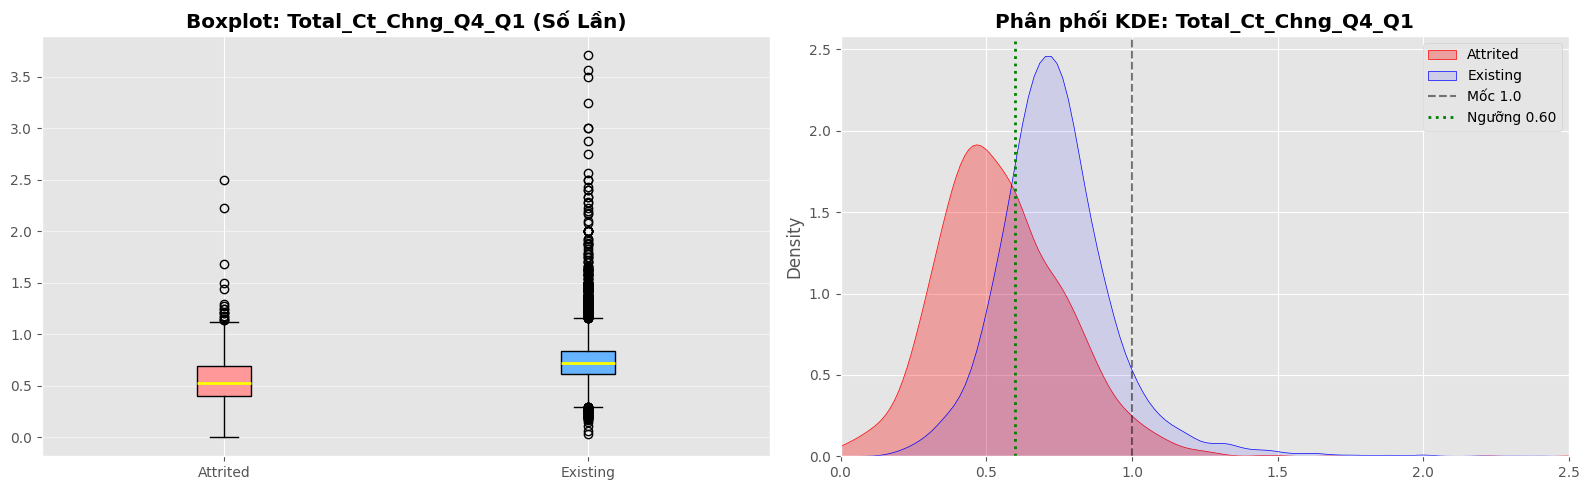

In [23]:

ct_col_idx = get_column_index(header, 'Total_Ct_Chng_Q4_Q1')
ct_vals = data[:, ct_col_idx].astype(float)
att_mask_calc = data[:, get_column_index(header, 'Attrition_Flag')] == 'Attrited Customer'
d_att_calc = ct_vals[att_mask_calc]
d_ext_calc = ct_vals[~att_mask_calc]
best_thresh = 0
max_diff = 0

for t in np.arange(0.0, 1.0, 0.05):
    diff = np.mean(d_att_calc < t) - np.mean(d_ext_calc < t)
    if diff > max_diff:
        max_diff = diff
        best_thresh = t

print(f"Ngưỡng tối ưu (threshold): {best_thresh:.2f} (Độ tách biệt: {max_diff*100:.1f}%)")
threshold = best_thresh

change_q4_q1_cols = [('Total_Amt_Chng_Q4_Q1', 'Số Tiền'), ('Total_Ct_Chng_Q4_Q1', 'Số Lần')]

print(f"{'='*60}\nPHÂN TÍCH SỰ THAY ĐỔI HÀNH VI GIAO DỊCH (Q4 vs Q1)\n{'='*60}")

for col, desc in change_q4_q1_cols:
    vals = data[:, get_column_index(header, col)].astype(float)
    d_att, d_ext = vals[att_mask_calc], vals[~att_mask_calc]
    
    med_a, med_e = np.median(d_att), np.median(d_ext)
    pct_a, pct_e = np.mean(d_att < threshold)*100, np.mean(d_ext < threshold)*100
    
    print(f"\n--- SO SÁNH: Thay đổi {desc} ({col}) ---")
    print(f"{'Chỉ số':<20} | {'Attrited':<11} | {'Existing':<11} | {'Chênh lệch'}")
    print(f"{'-'*60}\n{'Median':<20} | {med_a:<11.2f} | {med_e:<11.2f} | {med_a - med_e:.2f}")
    print(f"{f'Tỷ lệ < {threshold:.2f}':<20} | {pct_a:<10.1f}% | {pct_e:<10.1f}% | +{pct_a - pct_e:.1f}%")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    
    # Boxplot
    bplot = ax1.boxplot([d_att, d_ext], tick_labels=['Attrited', 'Existing'], patch_artist=True, 
                        medianprops=dict(color="yellow", linewidth=2))
    for patch, color in zip(bplot['boxes'], ['#ff9999', '#66b3ff']): patch.set_facecolor(color)
    ax1.set_title(f'Boxplot: {col} ({desc})', fontweight='bold'); ax1.grid(axis='y', alpha=0.5)

    # KDE Plot
    sns.kdeplot(d_att, ax=ax2, color='red', fill=True, alpha=0.3, label='Attrited')
    sns.kdeplot(d_ext, ax=ax2, color='blue', fill=True, alpha=0.1, label='Existing')
    ax2.axvline(1.0, color='black', linestyle='--', alpha=0.5, label='Mốc 1.0')
    ax2.axvline(threshold, color='green', linestyle=':', linewidth=2, label=f'Ngưỡng {threshold:.2f}')
    
    ax2.set_title(f'Phân phối KDE: {col}', fontweight='bold'); ax2.legend(); ax2.set_xlim(0, 2.5)
    
    plt.tight_layout(); plt.show()

### Nhận xét: Sự thay đổi Hành vi Giao dịch (Q4 vs Q1)

Kết quả phân tích cho thấy **sự sụt giảm tần suất sử dụng (số lần giao dịch)** là tín hiệu báo trước mạnh mẽ nhất cho việc khách hàng sắp rời bỏ.

**1. Thay đổi về SỐ LẦN giao dịch (`Total_Ct_Chng_Q4_Q1`)**
- **Sự sụt giảm nghiêm trọng:** Trung vị (Median) của nhóm Rời bỏ (Attrited) chỉ đạt **0.53**, thấp hơn nhiều so với nhóm Hiện tại (Existing) (**0.72**). Điều này có nghĩa là vào giai đoạn cuối (Q4), khách hàng sắp rời bỏ chỉ giao dịch bằng **một nửa** so với giai đoạn đầu (Q1).
- **Vùng nguy hiểm:** Có tới **61.8%** khách hàng rời bỏ có chỉ số này **< 0.6** (tức số lần giao dịch của khách hàng trong Quý 4 thấp hơn 60% so với Quý 1). Trong khi đó, chỉ **21.2%** khách hàng hiện tại rơi vào nhóm này.
- **Kết luận:** Sự "nguội lạnh" đột ngột trong thói quen quẹt thẻ là dấu hiệu rõ ràng nhất. Khách hàng giảm dần tần suất sử dụng trước khi rời đi.

**2. Thay đổi về SỐ TIỀN giao dịch (`Total_Amt_Chng_Q4_Q1`)**
- **Sự khác biệt ít rõ rệt hơn:** Mặc dù nhóm Rời bỏ có chỉ số thấp hơn (Median 0.70 so với 0.74), nhưng khoảng cách không quá lớn như số lần giao dịch.
- **Tuy nhiên:** Tỷ lệ khách hàng có mức giảm sâu (< 0.6) ở nhóm Rời bỏ (**32.9%**) vẫn cao gấp đôi so với nhóm Hiện tại (**16.6%**).

**Kết luận**
- Sự sụt giảm chỉ số **`Total_Ct_Chng_Q4_Q1` xuống dưới mức 0.6** là một "Cờ báo động đỏ". Ngân hàng có thể nhận biết ngay khi tỷ lệ thay đổi số lần giao dịch của một khách hàng tụt xuống dưới ngưỡng này.

## Câu hỏi 4: Có mối liên hệ ngược chiều nào giữa Hạn mức tín dụng (`Credit_Limit`) và Tỷ lệ sử dụng thẻ (`Avg_Utilization_Ratio`) không? Khách hàng có hạn mức cao nhưng không dùng (Utilization thấp) có dễ rời bỏ hơn không?

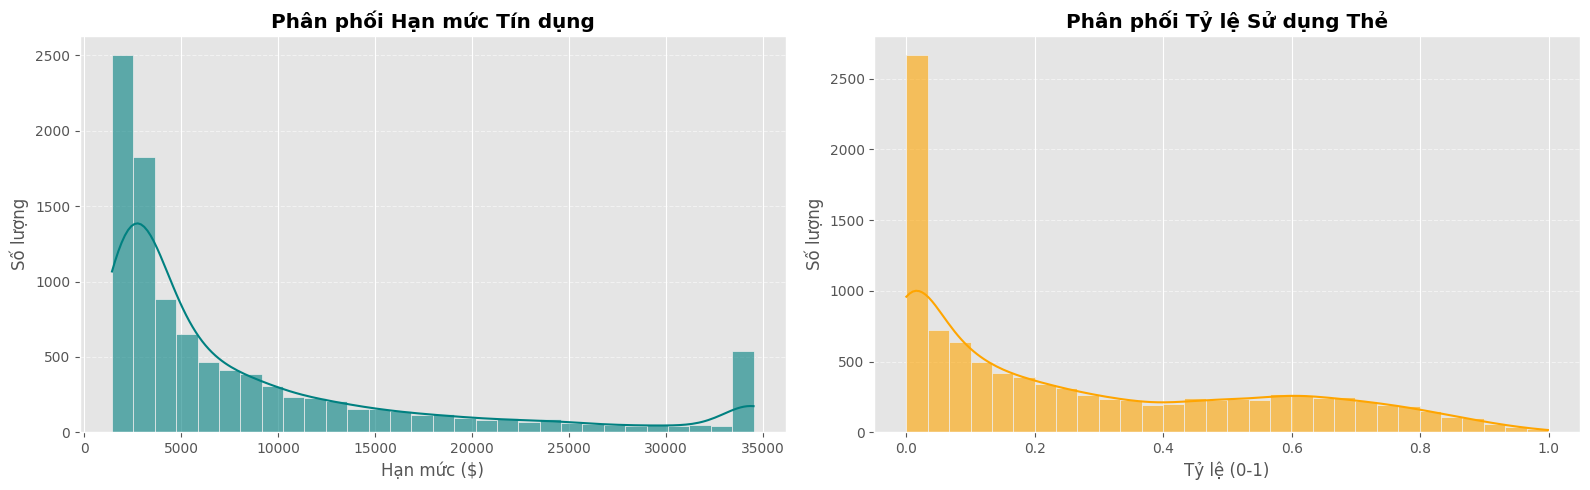

In [24]:
limit = data[:, get_column_index(header, 'Credit_Limit')].astype(float)
util = data[:, get_column_index(header, 'Avg_Utilization_Ratio')].astype(float)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

sns.histplot(limit, bins=30, kde=True, color='teal', alpha=0.6, ax=ax1)
ax1.set_title('Phân phối Hạn mức Tín dụng', fontweight='bold')
ax1.set_xlabel('Hạn mức ($)'); ax1.set_ylabel('Số lượng'); ax1.grid(axis='y', linestyle='--', alpha=0.5)

sns.histplot(util, bins=30, kde=True, color='orange', alpha=0.6, ax=ax2)
ax2.set_title('Phân phối Tỷ lệ Sử dụng Thẻ', fontweight='bold')
ax2.set_xlabel('Tỷ lệ (0-1)'); ax2.set_ylabel('Số lượng'); ax2.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout(); plt.show()

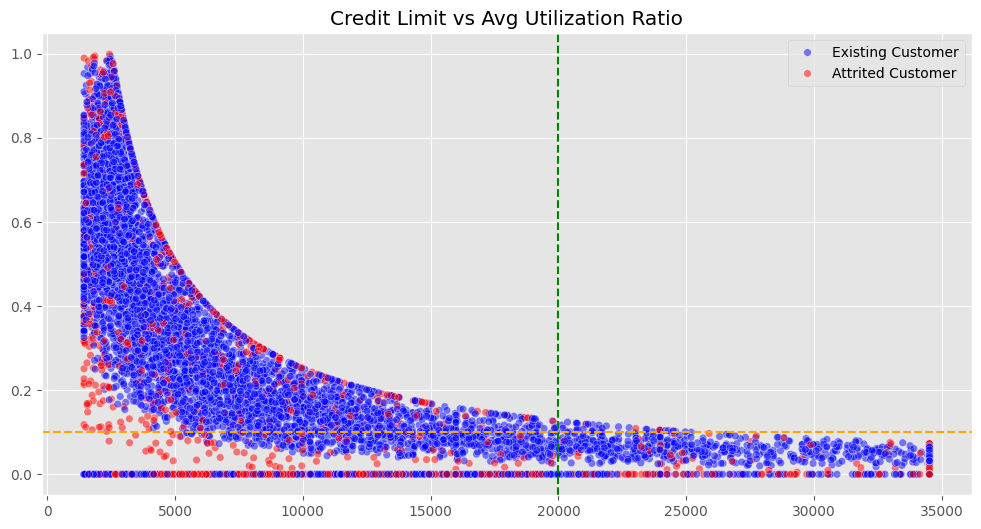

Nhóm có Limit > 20k và Util < 0.1: 181/1224 (14.79%)


In [25]:
att = data[:, get_column_index(header, 'Attrition_Flag')]

plt.figure(figsize=(12, 6))
sns.scatterplot(x=limit, y=util, hue=att, palette=['blue', 'red'], alpha=0.5, s=30)
plt.axvline(20000, color='g', ls='--'); plt.axhline(0.1, color='orange', ls='--')
plt.title('Credit Limit vs Avg Utilization Ratio'); plt.show()

mask = (limit > 20000) & (util < 0.1)
n_churn = np.sum(mask & (att == 'Attrited Customer'))
print(f"Nhóm có Limit > 20k và Util < 0.1: {n_churn}/{np.sum(mask)} ({n_churn/np.sum(mask)*100:.2f}%)")

### Nhận định:

**1. Quan hệ ngược chiều:**
- Biểu đồ phân tán (Scatter Plot) cho thấy một xu hướng "cánh cung" rất đặc trưng: Khi Hạn mức tín dụng (`Credit_Limit`) tăng lên, Tỷ lệ sử dụng (`Avg_Utilization_Ratio`) có xu hướng giảm mạnh và tiệm cận về 0.
- Điều này phản ánh bản chất toán học của tỷ lệ sử dụng (Balance / Limit). Tuy nhiên, dữ liệu còn cho thấy nhóm khách hàng có hạn mức rất cao (> 20k) thường duy trì số dư nợ rất thấp, dẫn đến tỷ lệ sử dụng gần như bằng 0.

**2. Phân khúc Rủi ro "Hạn mức cao - Không sử dụng" (High Limit - Low Usage):**
- Biểu đồ Scatter Plot làm nổi bật một nhóm khách hàng tập trung dày đặc ở góc dưới bên phải (**Hạn mức > 20k** và **Tỷ lệ sử dụng < 0.1**).
- Trong vùng này, các điểm màu đỏ (`Attrited Customer`) xuất hiện đáng kể. Điều này xác nhận giả thuyết: **Khách hàng được cấp hạn mức cao nhưng không sử dụng (hoặc dùng rất ít) có nguy cơ rời bỏ cao.**

**Kết luận:**
Có một mối liên hệ ngược chiều mạnh mẽ giữa hạn mức và tỷ lệ sử dụng. Đặc biệt, sự kết hợp giữa **Hạn mức cao (> 20k)** và **Tỷ lệ sử dụng thấp (< 10%)** tạo thành một "vùng trũng" rủi ro, nơi tỷ lệ rời bỏ cao hơn mức trung bình, đòi hỏi ngân hàng cần có chiến lược tiếp cận riêng cho tệp khách hàng này.